# Exploring the reference database
Let's see what properties we can find :) <br>
Let's put more data into it !

## Structure
In `genome/`, there's multiple sub-folder, we will start with `Bacteria`
It then contains all recorded species/strands in individual folders


## Content of each species/strand folder
In each folder there's:
- .ASN with 
 - `taxname "Acetobacter pasteurianus IFO 3283-32"`
 - `db "taxon", tag id 634457`
 - `genus "Acetobacter", species "pasteurianus"`
 - `mod { {subtype strain, subname "IFO 3283" }, { subtype substrain, subname "IFO 3283-32" } },`
 - `lineage "Bacteria; Proteobacteria; Alphaproteobacteria; Rhodospirillales; Acetobacteraceae; Acetobacter",`
- .FAA
 - with multiple ">gi|384064451|ref|YP_005479409.1| hypothetical protein APA32_44160 [Acetobacter pasteurianus IFO 3283-32]"
 - and probably the amino-acid sequence for each of these proteins
- .FFN
 - multiple ">gi|384064450|ref|NC_017102.1|:c562-116 Acetobacter pasteurianus IFO 3283-32 plasmid pAPA32-040, complete sequence"
 - probably DNA sequence
- .FNA
 - Also DNA
- .GBK : Human readable format with most info !
 - have an identifier `/db_xref="taxon:634457"`
- .GFF with `##species http://www.ncbi.nlm.nih.gov/Taxonomy/Browser/wwwtax.cgi?id=634457`
- .RPT
 - seem good with simple Python INI config file format: 
   - `DNA  length = 3035`
   - `Taxname: Acetobacter pasteurianus IFO 3283-32`
   - `Taxid: 634457`


http://defindit.com/readme_files/ncbi_file_extension_format.html

What we need is the taxo id, name, and the DNA, which can be found in:
 - .gbk for the taxo and name
 - .fna for the sequence

#### File marker
https://www.ncbi.nlm.nih.gov/books/NBK21091/table/ch18.T.refseq_accession_numbers_and_mole/?report=objectonly <br>
`NC_	Genomic	Complete genomic molecule, usually reference assembly`

#### Status
https://www.ncbi.nlm.nih.gov/books/NBK21091/table/ch18.T.refseq_status_codes/?report=objectonly <br>
in `COMMENT` : VALIDATED > REVIEWED > PROVISIONAL > ...


## Coding
### Import and Paths

In [132]:
import os
import pandas as pd
import numpy as np
import pickle
from time import time
from tqdm import tqdm_notebook as tqdm

In [2]:
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
path_ref_db = "/mnt/genomeDB/ncbi/genomes/Bacteria/"
path_kmer_freq = "/home/sjriondet/Data/Kmer_frequencies/"

In [6]:
path_4mer = "4_V3/"
path_4mer = os.path.join(path_kmer_freq, path_4mer)

In [12]:
path_all = os.path.join(path_4mer, "_all_bacteria_4mers.largepd")
path_all

'/home/sjriondet/Data/Kmer_frequencies/4_V3/_all_bacteria_4mers.largepd'

In [4]:
os.chdir(path_ref_db)

## Functions

In [5]:
def normalise_counts(kmer_count):
    """Nested dict, normalize each of the sub dict. """
    for window in kmer_count.keys():
        max_val = max(kmer_count[window].values())
        for key in kmer_count[window]:
            kmer_count[window][key] /= max_val

## Tests

In [137]:
names = []
files = []
counts = []
for f in os.scandir(path_4mer):
    if f.name.endswith(".pd") and not f.name.startswith("_"):
        files.append(f.path)
        names.append(os.path.splitext(f.name)[0])
#         with open(f, 'rb') as file:
#             counts.append(pickle.load(file))099
print(f"{len(names)} files")

2784 files


In [8]:
if False:
    df_concat = []
    for file in tqdm(files):
        df_concat.append(pd.read_pickle(file))

    all_df = pd.concat(df_concat)

    all_df.bacteria = all_df.bacteria.astype("category")
    all_df.fna = all_df.fna.astype("category")

In [9]:
df = pd.read_pickle(files[0])

In [151]:
cols_kmers = df.columns.to_list()[4:]

In [11]:
cols_spe = sorted(list(set(df.columns.to_list()).difference(set(cols_kmers))))

Load the whole dataset. Will take a while !!

In [13]:
all_all_df = pd.read_pickle(path_all)

In [14]:
all_all_df.sample(5)

,bacteria,fna,len_genome,start,AAAA,AAAC,AAAG,AAAT,AACA,AACC,...,TTCG,TTCT,TTGA,TTGC,TTGG,TTGT,TTTA,TTTC,TTTG,TTTT
2788,Escherichia_coli_O103_H2_12009_uid41013,NC_013353,5449314,2788000,4,6,6,2,8,6,...,4,2,1,3,1,2,2,2,1,0
1762,Ruminococcus_bromii_uid197158,NC_021013,2249085,1762000,4,2,3,5,2,2,...,1,8,6,8,1,10,11,12,8,18
5459,Pantoea_At_9b_uid55845,NC_014839,394054,298000,11,3,3,9,7,2,...,3,8,6,4,2,3,6,6,4,9
2655,Rhodopseudomonas_palustris_TIE_1_uid58995,NC_011004,5744041,2655000,1,0,0,3,2,2,...,6,7,4,9,5,1,2,9,5,8
4156,Enterobacter_cloacae_dissolvens_SDM_uid168997,NC_018079,4968248,4156000,2,3,2,0,0,2,...,9,2,4,2,4,1,6,9,3,6


In [144]:
n_samples = 100000
n_bacteria = 100

In [145]:
all_df = all_all_df[all_all_df.bacteria.isin(all_all_df.bacteria.unique()[:n_bacteria])].sample(n_samples)

In [146]:
all_all_df.shape, all_df.shape

((9620234, 260), (100000, 260))

In [147]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [153]:
len(cols_kmers)

256

In [57]:
pca = PCA(n_components=50)
pca.fit(all_df[cols_kmers])

PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

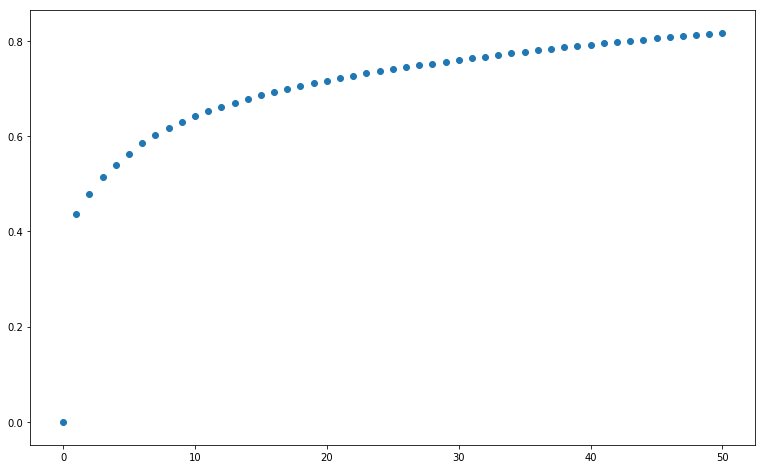

captured by PCA: 81.7%


In [58]:
plt.scatter(x=range(len(pca.explained_variance_ratio_)+1), 
            y=np.insert(pca.explained_variance_ratio_.cumsum(), 0, 0))
# plt.plot(pca.explained_variance_ratio_)
plt.show()
print(f"captured by PCA: {sum(pca.explained_variance_ratio_)*100:0.1f}%")

In [59]:
pca_n = 10

In [60]:
pca = PCA(n_components=pca_n)
pca.fit(all_df[cols_kmers])

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [61]:
np_pca = pca.transform(all_df[cols_kmers])

In [62]:
cols_pca = [f"pca_{i+1}" for i in range(pca_n)]

In [63]:
df_pca = pd.DataFrame(np_pca, columns=cols_pca)

In [64]:
df_pca = pd.concat([all_df[cols_spe].reset_index(inplace=False, drop=True), df_pca], axis=1) # , ignore_index=True)

In [65]:
df_pca

,bacteria,fna,len_genome,start,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10
0,Fluviicola_taffensis_DSM_16823_uid65271,NC_015321,4633577,4059000,49.10,-2.18,-3.40,-6.27,-1.49,1.68,-0.12,14.68,9.66,0.94
1,Riemerella_anatipestifer_RA_GD_uid162013,NC_017569,2166384,1258000,52.68,7.63,-16.90,3.57,5.25,-5.53,-5.41,-9.37,-1.08,-4.53
2,Burkholderia_gladioli_BSR3_uid66301,NC_015376,3700833,3479000,-51.96,14.90,-0.56,-4.62,-14.84,15.77,-4.10,-2.22,-1.27,-6.96
3,Zunongwangia_profunda_SM_A87_uid48073,NC_014041,5128187,1843000,40.76,-0.56,12.26,-1.41,-2.05,-4.70,-3.79,9.27,-2.15,-8.82
4,Vibrio_parahaemolyticus_RIMD_2210633_uid57969,NC_004605,1877212,950000,27.78,-9.56,-8.16,-7.16,0.71,-0.95,-1.04,-3.52,6.10,1.15
5,Xanthomonas_axonopodis_citrumelo_F1_uid73179,NC_016010,4967469,3428000,-37.47,4.79,0.36,-9.22,-5.70,1.94,-5.65,-0.69,-0.99,-3.35
6,Escherichia_coli_O55_H7_CB9615_uid46655,NC_013941,5386352,921000,6.28,-13.79,-7.88,-1.89,-1.28,-5.48,6.22,-2.75,1.27,-5.48
7,Zunongwangia_profunda_SM_A87_uid48073,NC_014041,5128187,1417000,61.84,12.40,18.43,2.48,4.28,3.05,1.74,3.49,-1.39,-2.01
8,Mycobacterium_canettii_CIPT_140070017_uid184830,NC_019952,4524466,16000,-29.77,-6.89,-1.43,2.94,10.29,-12.91,-10.99,-6.21,18.92,2.71
9,Streptococcus_thermophilus_MN_ZLW_002_uid166827,NC_017927,1848520,686000,24.49,-22.28,2.68,-10.70,4.17,-2.65,-2.24,-2.21,5.60,-1.50


In [66]:
df_pca["color_map"] = 0
for i, bacteria in enumerate(df_pca.bacteria.unique()):
    df_pca.loc[df_pca["bacteria"] == bacteria, ['color_map']] = i

In [67]:
df_pca.shape

(100000, 15)

In [68]:
df_pca

,bacteria,fna,len_genome,start,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,color_map
0,Fluviicola_taffensis_DSM_16823_uid65271,NC_015321,4633577,4059000,49.10,-2.18,-3.40,-6.27,-1.49,1.68,-0.12,14.68,9.66,0.94,0
1,Riemerella_anatipestifer_RA_GD_uid162013,NC_017569,2166384,1258000,52.68,7.63,-16.90,3.57,5.25,-5.53,-5.41,-9.37,-1.08,-4.53,1
2,Burkholderia_gladioli_BSR3_uid66301,NC_015376,3700833,3479000,-51.96,14.90,-0.56,-4.62,-14.84,15.77,-4.10,-2.22,-1.27,-6.96,2
3,Zunongwangia_profunda_SM_A87_uid48073,NC_014041,5128187,1843000,40.76,-0.56,12.26,-1.41,-2.05,-4.70,-3.79,9.27,-2.15,-8.82,3
4,Vibrio_parahaemolyticus_RIMD_2210633_uid57969,NC_004605,1877212,950000,27.78,-9.56,-8.16,-7.16,0.71,-0.95,-1.04,-3.52,6.10,1.15,4
5,Xanthomonas_axonopodis_citrumelo_F1_uid73179,NC_016010,4967469,3428000,-37.47,4.79,0.36,-9.22,-5.70,1.94,-5.65,-0.69,-0.99,-3.35,5
6,Escherichia_coli_O55_H7_CB9615_uid46655,NC_013941,5386352,921000,6.28,-13.79,-7.88,-1.89,-1.28,-5.48,6.22,-2.75,1.27,-5.48,6
7,Zunongwangia_profunda_SM_A87_uid48073,NC_014041,5128187,1417000,61.84,12.40,18.43,2.48,4.28,3.05,1.74,3.49,-1.39,-2.01,3
8,Mycobacterium_canettii_CIPT_140070017_uid184830,NC_019952,4524466,16000,-29.77,-6.89,-1.43,2.94,10.29,-12.91,-10.99,-6.21,18.92,2.71,7
9,Streptococcus_thermophilus_MN_ZLW_002_uid166827,NC_017927,1848520,686000,24.49,-22.28,2.68,-10.70,4.17,-2.65,-2.24,-2.21,5.60,-1.50,8


In [69]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 13, 8

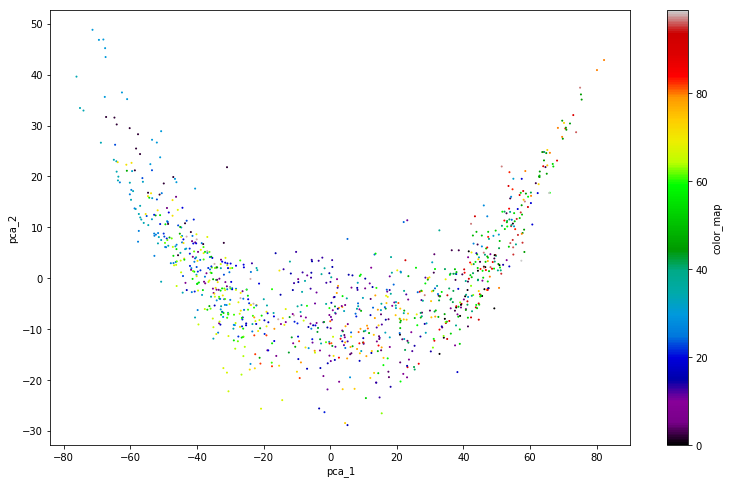

captured by PCA: 47.8%


In [70]:
df_pca.sample(1000).plot.scatter(x="pca_1", y="pca_2", s=1, c="color_map", colormap="nipy_spectral")  # gist_ncar
plt.show()
print(f"captured by PCA: {sum(pca.explained_variance_ratio_[:2])*100:0.1f}%")

## Machine Learning classification

In [71]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, scale

In [72]:
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import ElasticNet
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [149]:
cols_spe

['bacteria', 'fna', 'len_genome', 'start']

In [154]:
# Without PCA
X_train, X_test, y_train, y_test = train_test_split(scale(all_df[cols_kmers]), all_df.bacteria, 
                                                    test_size=0.1, random_state=0)

/opt/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: DataConversionWarning: Data with input dtype uint16 were all converted to float64 by the scale function.
  from ipykernel import kernelapp as app


In [155]:
models = {
    "RF": RandomForestClassifier(max_depth=20, random_state=0, n_estimators=100, n_jobs=6),
    "SVM_lin": SVC(kernel="linear", C=0.025),
    "SVM_rbf": SVC(kernel='rbf', C=1, gamma='auto', cache_size=1000),
    "KNeigh": KNeighborsClassifier(n_neighbors=20, n_jobs=6),
    "DTree": DecisionTreeClassifier(max_depth=20),
    "NNet": MLPClassifier(alpha=1),
    "AdaBoost": AdaBoostClassifier(),
    "Naive_Bayes": GaussianNB(),
    "QDA": QuadraticDiscriminantAnalysis()
}

In [156]:
results = {}

In [ ]:
for name in tqdm(models.keys()):
    if name not in results.keys():
        print(name)
        start = time()
        results[name] = {}
        
        models[name].fit(X_train, y_train)
        time_fitted = time()
        results[name]["time_fit"] = time_fitted - start
        
        predicted = models[name].predict(X_test)
        results[name]["time_predict"] = time() - time_fitted
        
        score = models[name].score(X_test, y_test)
        
        results[name]["time"] = time() - start
        results[name]["score"] = score
        results[name]["predicted"] = predicted
    

RF
SVM_lin


In [ ]:
path_models = "ml_models/"
path_models = os.path.join(path_4mer, path_models)

In [ ]:
if False:
    for model in tqdm(models.keys()):
        with open(os.path.join(path_models, f"_{model}_NoPCA_{n_samples}samples_{n_bacteria}bac.pkl"), 'wb') as f_out:
            pickle.dump(models[model], f_out)

In [ ]:
to_df = {"Ground_Truth": y_test}
for name in results.keys():
    predicted = results[name]["predicted"]
    to_df[f"{name}"] = (y_test==predicted).astype(int)
    to_df[f"{name}_pred"] = predicted
pd_res = pd.DataFrame(to_df)

In [ ]:
ranking = 100 * pd_res.sum(numeric_only=True) / pd_res.RF.count()

In [ ]:
pd_ranking = pd.DataFrame({"name": ranking.index.values, 
                           "percentage": ranking.values})

TODO: add fit time and pred time

In [ ]:
pd_ranking["time"] = 0
for name in results.keys():
    pd_ranking.loc[pd_ranking["name"] == name, ['time']] = results[name]["time"]

Results for 100,000 samples from 100 species, NO PCA

In [ ]:
pd_ranking.sort_values(by=["percentage"], ascending=False)

Results for 100,000 samples from 100 species, with PCA

In [95]:
pd_ranking.sort_values(by=["percentage"], ascending=False)

,name,percentage,time
2,SVM_rbf,46.72,448.23
8,QDA,46.17,0.53
0,RF,44.11,18.23
1,SVM_lin,41.75,346.49
3,KNeigh,40.99,5.65
7,Naive_Bayes,39.55,0.60
5,NNet,38.76,84.88
4,DTree,32.99,5.01
6,AdaBoost,7.40,58.29


Results for 10,000 samples from 100 species, with PCA

In [52]:
pd_ranking.sort_values(by=["percentage"], ascending=False)

,name,percentage,time
2,SVM_rbf,40.50,6.79
8,QDA,38.90,0.08
0,RF,38.80,1.78
5,NNet,38.10,26.52
7,Naive_Bayes,38.00,0.08
1,SVM_lin,33.20,4.46
3,KNeigh,31.10,0.49
4,DTree,26.70,0.39
6,AdaBoost,5.70,5.48


In [ ]:
pd_res

In [97]:
all_df.sample(5)

,bacteria,fna,len_genome,start,AAAA,AAAC,AAAG,AAAT,AACA,AACC,...,TTCG,TTCT,TTGA,TTGC,TTGG,TTGT,TTTA,TTTC,TTTG,TTTT
1313,Pseudogulbenkiania_NH8B_uid73423,NC_016002,4332995,1313000,3,2,0,2,2,2,...,4,2,4,8,6,4,0,3,3,0
927,Francisella_tularensis_holarctica_FSC200_uid54341,NC_019551,1894157,927000,6,7,5,7,4,3,...,3,4,14,5,5,16,15,10,16,41
626,Dehalococcoides_VS_uid42393,NC_013552,1413462,626000,11,6,12,10,2,5,...,1,8,7,4,7,3,4,9,6,12
5,Clostridium_botulinum_Ba4_657_uid59173,NC_012654,270022,5000,20,7,4,21,8,0,...,0,16,6,2,2,8,20,11,9,18
653,Salmonella_enterica_serovar_Bovismorbificans_3...,NC_022241,4677483,653000,8,5,7,6,2,7,...,3,3,1,1,3,1,6,9,2,7


In [100]:
all_df[all_df.fna.str.contains("NC")].shape

(100000, 260)

In [111]:
all_df.loc[all_df.bacteria.str.contains("Salmonella_enterica_serovar_Bovismorbificans_3"), "fna"].unique()

[NC_022241, NC_022248]
Categories (2, object): [NC_022241, NC_022248]

In [123]:
all_df[(all_df.bacteria.str.contains("Salmonella_enterica_serovar_Bovismorbificans_3"))].len_genome.unique()

array([4677483,   93046])

In [124]:
y_test

['Pseudomonas_aeruginosa_PAO581_uid219357',
 'Mycobacterium_tuberculosis_RGTB327_uid157907',
 'Rickettsia_massiliae_AZT80_uid86751',
 'Francisella_tularensis_holarctica_FSC200_uid54341',
 'Mycobacterium_abscessus_uid61613',
 'Salmonella_enterica_serovar_Bovismorbificans_3114_uid218006',
 'Magnetospirillum_magneticum_AMB_1_uid58527',
 'Geobacter_sulfurreducens_KN400_uid161977',
 'Corynebacterium_halotolerans_YIM_70093___DSM_44683_uid189953',
 'Chamaesiphon_minutus_PCC_6605_uid183005',
 'Burkholderia_pseudomallei_668_uid58389',
 'Helicobacter_pylori_SouthAfrica20_uid216150',
 'Escherichia_coli_O7_K1_CE10_uid162115',
 'Acidithiobacillus_ferrooxidans_ATCC_23270_uid57649',
 'Fluviicola_taffensis_DSM_16823_uid65271',
 'Escherichia_coli_O55_H7_CB9615_uid46655',
 'Actinoplanes_friuliensis_DSM_7358_uid226110',
 'Escherichia_coli_O55_H7_CB9615_uid46655',
 'Cyanothece_PCC_7822_uid52547',
 'Francisella_tularensis_holarctica_FSC200_uid54341',
 'Bacillus_cytotoxicus_NVH_391_98_uid58317',
 'Zunongwan

In [125]:
df_pca1000.bacteria

0                  Fluviicola_taffensis_DSM_16823_uid65271
1                 Riemerella_anatipestifer_RA_GD_uid162013
2                      Burkholderia_gladioli_BSR3_uid66301
3                    Zunongwangia_profunda_SM_A87_uid48073
4            Vibrio_parahaemolyticus_RIMD_2210633_uid57969
5             Xanthomonas_axonopodis_citrumelo_F1_uid73179
6                  Escherichia_coli_O55_H7_CB9615_uid46655
7                    Zunongwangia_profunda_SM_A87_uid48073
8          Mycobacterium_canettii_CIPT_140070017_uid184830
9          Streptococcus_thermophilus_MN_ZLW_002_uid166827
10                 Escherichia_coli_O55_H7_CB9615_uid46655
11                           Aquifex_aeolicus_VF5_uid57765
12                 Fluviicola_taffensis_DSM_16823_uid65271
13                   Escherichia_coli_O7_K1_CE10_uid162115
14                     Burkholderia_gladioli_BSR3_uid66301
15                          Escherichia_coli_SE11_uid59425
16                           Psychrobacter_PRwf_1_uid584



### End of the script.
Sylvain @GIS

In [229]:
def randForest():
    if verbose:  print("Random Forest Classification")
    rf_regr = RandomForestClassifier(max_depth=20, random_state=0, n_estimators=100, n_jobs=6)
    rf_regr.fit(X_train, y_train)
    return rf_regr

In [230]:
rf_cl = randForest()
score = rf_cl.score(X_test, y_test)
score

Random Forest Classification


0.48999999999999999

In [233]:
predicted = rf_cl.predict(X_test)

In [235]:
pd_res = pd.DataFrame({"Ground_Truth": y_test, "Got_it": y_test==predicted, "Predicted": predicted})
pd_res

,Ground_Truth,Got_it,Predicted
0,Acetobacter_pasteurianus_IFO_3283_07_uid158381,False,Achromobacter_xylosoxidans_A8_uid59899
1,Acetohalobium_arabaticum_DSM_5501_uid51423,True,Acetohalobium_arabaticum_DSM_5501_uid51423
2,Achromobacter_xylosoxidans_uid205255,False,Achromobacter_xylosoxidans_NBRC_15126_uid232243
3,Achromobacter_xylosoxidans_NBRC_15126_uid232243,True,Achromobacter_xylosoxidans_NBRC_15126_uid232243
4,Achromobacter_xylosoxidans_NBRC_15126_uid232243,True,Achromobacter_xylosoxidans_NBRC_15126_uid232243
5,Acidianus_hospitalis_W1_uid66875,True,Acidianus_hospitalis_W1_uid66875
6,Acetobacter_pasteurianus_IFO_3283_01_uid59279,False,Acetobacter_pasteurianus_IFO_3283_32_uid158375
7,Acholeplasma_laidlawii_PG_8A_uid58901,True,Acholeplasma_laidlawii_PG_8A_uid58901
8,Achromobacter_xylosoxidans_uid205255,True,Achromobacter_xylosoxidans_uid205255
9,Acetohalobium_arabaticum_DSM_5501_uid51423,True,Acetohalobium_arabaticum_DSM_5501_uid51423


In [180]:
def svr():
    if verbose:  print("Support Vector Machine regression")
    svr_rbf = SVC(kernel='rbf', gamma='auto', cache_size=1000)
    svr_rbf.fit(X_train, y_train)
    return svr_rbf

In [181]:
svr_rbf = svr()
svr_pred = error_and_corr(svr_rbf)
some_predictions(svr_pred)

Support Vector Machine regression
Pearson correlation	: *0.396*
Mean squared error	: 450474419.036
Expected values 	: 20750.00	60975.00	6943.00	43743.00	37827.00	35247.00	14456.00	20457.00	63387.00	64819.00
Predicted values 	: 36217.67	41153.16	37715.84	40516.99	37342.60	37451.71	40153.87	36616.17	39658.96	39800.07


In [182]:
def k_neigh():
    if verbose:  print("K neighbours")
    neigh = KNeighborsRegressor(n_neighbors=20, n_jobs=6)
    neigh.fit(X_train, y_train)
    return neigh

In [183]:
neigh = k_neigh()
n_pred = error_and_corr(neigh)
some_predictions(n_pred)

K neighbours
Pearson correlation	: *0.671*
Mean squared error	: 260134584.829
Expected values 	: 20750.00	60975.00	6943.00	43743.00	37827.00	35247.00	14456.00	20457.00	63387.00	64819.00
Predicted values 	: 26281.15	56710.45	5391.20	32758.30	32224.10	27731.05	38815.25	26915.65	37706.80	40203.70


In [ ]:
def elas_net():
    if verbose:  print("Elastic Net")
    elastic_net = ElasticNet(l1_ratio=0.5, random_state=0)
    elastic_net.fit(X_train, y_train)
    return elastic_net

In [ ]:
e_net = elas_net()
e_pred = error_and_corr(e_net)
some_predictions(e_pred)

In [ ]:
def nn():
    if verbose:  print("Neural Network")
    nnm = MLPRegressor(hidden_layer_sizes=(100,100,), verbose=False, tol=0.000100)
    nnm.fit(X_train, y_train)
    return nnm

In [ ]:
nn_m = nn()
nn_pred = error_and_corr(nn_m)
some_predictions(nn_pred)

In [ ]:
models = [linReg, randForest, svr, k_neigh, elas_net, nn]

In [ ]:
results = {}
for model in tqdm(models):
    print("******************************************")
    m = model()
    pred = error_and_corr(m)
    # some_predictions(pred)
    pearson, err = error_and_corr(m, re_val=True)
    results[model.__name__] = {"pearson": pearson, "err": err}

In [ ]:
pred = error_and_corr(models[1](), display=False)

In [ ]:
pd.DataFrame([pred, y_test.values])

In [ ]:
from datetime import datetime
file_results = "results.csv"
file_results = osp.join(folder, file_results)

In [ ]:
with open(file_results, "a") as f:
    f.write(str(datetime.now())[:16] + "," + str(param) + "," + "\n")
    f.write(",".join(results.keys()) + "\n")
    f.write(",".join([f"{v['pearson']:.3f}" for v in results.values()]) + "\n")
    f.write(",".join([f"{v['err']:.3f}" for v in results.values()]) + "\n")
    print(f"Results written in {file_results}")

https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

In [198]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

In [206]:
results = {}
for name, clf in tqdm(zip(names, classifiers), total=len(names), desc="Classifiers"):
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    results[name] = score

KeyboardInterrupt: 



### End of the script.
Sylvain @GIS

## Keep other methods

ML stuff

In [159]:
def scale_minmax(df, single_col=False):
    df = df + 1
    df = df.apply(np.log2)
    if single_col:
        return MinMaxScaler().fit_transform(df.values.reshape(-1, 1))
    else:
        return MinMaxScaler().fit_transform(df)

In [160]:
def error_and_corr(model, display=True, re_val=False):
    prediction = model.predict(X_test)
    pearson = np.corrcoef(prediction, y_test)[0, 1]
    mean_square_err = mean_squared_error(y_test, prediction)
    if re_val:
        return pearson, mean_square_err
    if display:
        print(f"Pearson correlation\t: *{pearson:.3f}*")
        print(f"Mean squared error\t: {mean_square_err:.3f}")
    return prediction

In [161]:
def some_predictions(pred):
    print("Expected values \t: " + "\t".join([f"{n:.2f}" for n in y_test[:10]]))
    print("Predicted values \t: " + "\t".join([f"{n:.2f}" for n in pred[:10]]))

kmers stuff

In [ ]:
def window(fseq, window_size=53):
    for i in range(len(fseq) - window_size + 1):
        yield fseq[i:i+window_size]

In [ ]:
def kmer_pkl_path(k, fna_path):
    path_gbk = fna_path.replace(".fna", ".gbk")
    assert os.path.isfile(path_gbk), f"{fna_path} DOESN'T have a .gbk file ??"
    
    with open(path_gbk) as gbk:
        description=gbk.read()  #.replace('\n', '')
        
    identificator = 'db_xref="taxon:'
    taxo_start = description.find(identificator)
    taxo = description[taxo_start+len(identificator):
                       taxo_start+description[taxo_start:].find('"\n')]
    assert len(taxo) < 10, f"The taxo id search failed, found an id of length {len(taxo)}..."
    
    # TODO: ADD full path of the original file in the file name, or maybe in the .pkl
    
    return os.path.join(path_kmer_freq, str(k), taxo + ".pkl")

In [ ]:
def kmer_freq_to_file(kmer_dic, freq_path):
    with open(freq_path, 'wb') as f_out:
        pickle.dump(kmer_dic, f_out)